# Error Analysis

Find localisation error using control lines

The strategy is the following:

- Register points across channels before and after chromatic aberration correction
- Do the step above using multiple distance cutoff on registration
- Error will be given by the standard deviation of the distances after correction

In [1]:
import glob
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
import scipy.optimize
import scipy.stats
sys.path.append("../source/")
from dual_channel_analysis.utils import *
from IPython.display import Markdown as md
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.use("Agg")

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
def register_points_using_euclidean_distance(
    reference: pd.DataFrame, moving: pd.DataFrame, distance_cutoff: float = 0.1
):
    """Given dataframe containing reference and moving coordinates, get the two sets of matched points"""

    cdist = scipy.spatial.distance.cdist(reference, moving, metric="euclidean")
    rows, cols = scipy.optimize.linear_sum_assignment(cdist)
    for r, c in zip(rows, cols):
        if cdist[r, c] > distance_cutoff:
            rows = rows[rows != r]
            cols = cols[cols != c]

    reference = np.array([reference[i] for i in rows])
    moving = np.array([moving[i] for i in cols])

    return reference, moving


def calculate_deviation_registred_points(channel1_files, channel2_files, path_beads):
    res = pd.DataFrame()

    for dist_cutoff in [
        0.08,
        0.09,
        0.1,
        0.11,
        0.12,
        0.13,
        0.14,
        0.15,
        0.16,
        0.17,
        0.18,
        0.19,
        0.2,
        0.3,
        0.5,
        0.6,
        0.7,
        0.8,
        0.9,
        1.0,
    ]:

        channel1_coords = []
        channel2_coords = []
        channel1_coords_after_correction = []
        channel2_coords_after_correction = []

        for idx in range(len(channel1_files)):

            channel1 = pd.read_csv(channel1_files[idx])
            channel2 = pd.read_csv(channel2_files[idx])

            (
                channel1_coords_curr,
                channel2_coords_curr,
            ) = register_points_using_euclidean_distance(
                reference=channel1[[X, Y, Z]].values,
                moving=channel2[[X, Y, Z]].values,
                distance_cutoff=dist_cutoff,
            )

            (
                channel2_coords_after_correction_curr,
                sx,
                sy,
                sz,
            ) = chromatic_aberration_correction(
                directory=path_beads,
                coords=channel2[[X, Y, Z]].values,
                channel_to_correct=2,
                distance_cutoff=0.1,
                quality=f"{outdir}/chromatic_aberration_correction_quality.pdf",
            )

            (
                channel1_coords_after_correction_curr,
                channel2_coords_after_correction_curr,
            ) = register_points_using_euclidean_distance(
                reference=channel1[[X, Y, Z]].values,
                moving=channel2_coords_after_correction_curr,
                distance_cutoff=dist_cutoff,
            )

            if len(channel1_coords_curr):
                channel1_coords.append(channel1_coords_curr)

            if len(channel2_coords_curr):
                channel2_coords.append(channel2_coords_curr)

            if len(channel1_coords_after_correction_curr):
                channel1_coords_after_correction.append(
                    channel1_coords_after_correction_curr
                )
            if len(channel2_coords_after_correction_curr):
                channel2_coords_after_correction.append(
                    channel2_coords_after_correction_curr
                )

        if len(channel1_coords) == 0 and len(channel1_coords_after_correction) == 0:
            continue
        channel1_coords = np.concatenate(channel1_coords)
        channel2_coords = np.concatenate(channel2_coords)
        channel1_coords_after_correction = np.concatenate(
            channel1_coords_after_correction
        )
        channel2_coords_after_correction = np.concatenate(
            channel2_coords_after_correction
        )

        A, t = calculate_rototranslation_3D(
            channel1_coords_after_correction, channel2_coords_after_correction
        )
        channel2_coords_after_correction = (
            np.transpose(np.dot(A, channel2_coords_after_correction.T) + t) 
        )

        dist1 = np.sqrt(
            np.sum(
                np.square(
                    channel1_coords_after_correction - channel2_coords_after_correction
                ),
                axis=1,
            )
        )

        dist2 = np.sqrt(
            np.sum(
                np.square(channel1_coords - channel2_coords),
                axis=1,
            )
        )
        tmp = pd.DataFrame(dist1, columns=["distance_after"])
        tmp["dist_cutoff"] = dist_cutoff

        axis = ["x", "y", "z"]
        for i in range(len(axis)):
            diff1 = (
                channel1_coords_after_correction[..., i]
                - channel2_coords_after_correction[..., i]
            )
            diff2 = channel1_coords[..., i] - channel2_coords[..., i]

            tmp[f"{axis[i]}_after"] = diff1
            #    tmp[f"{axis[i]}_before"] = diff2
            res = pd.concat([res, tmp])
    return res


def plotres(res):
    fig, ax = plt.subplots(3, 4, figsize=(15, 15))
    axis = ["x", "y", "z"]
    i = 0
    selection = res.axis == axis[i]
    ax[0, i].plot(res.dist_cutoff[selection], res.number_points_before[selection], "-o")
    ax[0, i].set_ylabel("Number of registred points")
    for i in range(len(axis)):
        selection = res.axis == axis[i]
        ax[1, i].axhline(y=0, color="r", linestyle="-")
        ax[1, i].plot(res.dist_cutoff[selection], res.mean_before[selection], "-o")
        ax[1, i].plot(res.dist_cutoff[selection], res.mean_after[selection], "-o")
        ax[1, i].legend(["Before correction", "After correction"])
        if i == 0:
            ax[1, i].set_ylabel("Average distance between registred spots")
        ax[1, i].set_title(f"Along {axis[i]}")

    ax[1, 3].plot(res.dist_cutoff[selection], res.mean_before_distance[selection], "-o")
    ax[1, 3].plot(res.dist_cutoff[selection], res.mean_after_distance[selection], "-o")
    ax[1, 3].legend(["Before correction", "After correction"])
    ax[1, 3].set_title(f"radial distance")

    for i in range(len(axis)):
        selection = res.axis == axis[i]
        ax[2, i].plot(res.dist_cutoff[selection], res.sd_before[selection], "-o")
        ax[2, i].plot(res.dist_cutoff[selection], res.sd_after[selection], "-o")
        ax[2, i].legend(["Before correction", "After correction"])
        ax[2, i].set_xlabel("Distance cutoff for points registration")
        if i == 0:
            ax[2, i].set_ylabel("STD of distance between registred spots")
    plt.suptitle(f"{outdir}", fontsize=20)

    ax[2, 3].plot(res.dist_cutoff[selection], res.sd_before_distance[selection], "-o")
    ax[2, 3].plot(res.dist_cutoff[selection], res.sd_after_distance[selection], "-o")
    ax[2, 3].legend(["Before correction", "After correction"])
    ax[2, 3].set_xlabel("Distance cutoff for points registration")

    plt.savefig(f"{outdir}/{outname}.error_analysis.pdf")
    plt.show()

In [3]:
TRACKID = "track"
X = "x"
Y = "y"
Z = "z"
FRAME = "frame"
CELLID = "cell"
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/control_lines_new/"

In [4]:
res = pd.DataFrame()
outdir = f"{basedir}/"
outname = "alldatapooled"
for sample in glob.glob(f"{basedir}/*/"):
    path_beads = f"{sample}/beads/um_based/"
    path_images_to_correct = f"{sample}/um_based/"

    channel1_files = sorted(glob.glob(f"{path_images_to_correct}/*w1*csv"))
    names = [re.search(r"(^.*)w1", os.path.basename(x))[1] for x in channel1_files]
    channel2_files = [
        glob.glob(f"{path_images_to_correct}/{name}*w2*csv")[0] for name in names
    ]

    tmp = calculate_deviation_registred_points(channel1_files, channel2_files, path_beads)
    tmp["exp"] = sample
    res = pd.concat([tmp, res])

# plotres(res0)
# md(
#     f"Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following offset  {res0[round(res0.dist_cutoff, 1)==0.3]['mean_after_distance'].values[0]} +/- {res0[round(res0.dist_cutoff, 1)==0.3]['sd_after_distance'].values[0]}"
# )

In [5]:
res.to_csv(f"{basedir}/{outname}.csv", index=False)

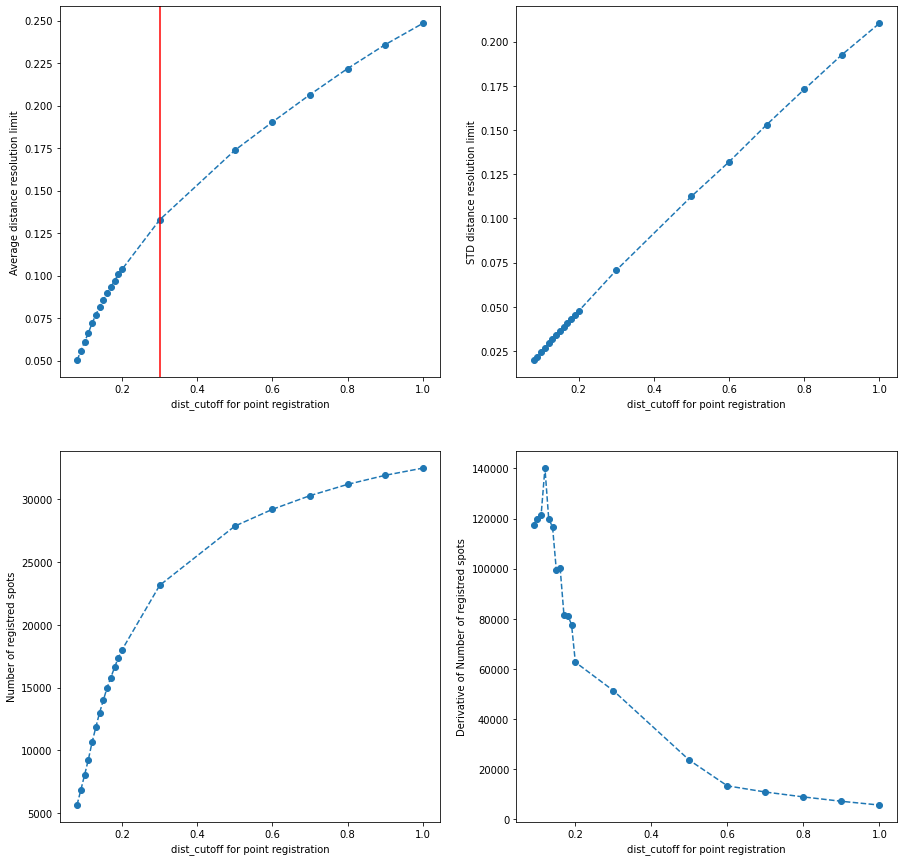

In [6]:
pdf = PdfPages(f"{basedir}/resolution_limit.pdf")
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].plot(res.groupby("dist_cutoff").mean()["distance_after"], "--o")
ax[0,0].set_xlabel("dist_cutoff for point registration")
ax[0,0].set_ylabel("Average distance resolution limit")
ax[0,0].axvline(0.3, color="r")

ax[0,1].plot(res.groupby("dist_cutoff").std()["distance_after"], "--o")
ax[0,1].set_xlabel("dist_cutoff for point registration")
ax[0,1].set_ylabel("STD distance resolution limit")


ax[1,0].plot(res.groupby("dist_cutoff")["distance_after"].apply(lambda x: len(x)), "--o")
ax[1,0].set_xlabel("dist_cutoff for point registration")
ax[1,0].set_ylabel("Number of registred spots")


x = res.groupby("dist_cutoff")["distance_after"].apply(lambda x: len(x)).index.values
y = res.groupby("dist_cutoff")["distance_after"].apply(lambda x: len(x)).values

ax[1,1].plot(x[1:], np.diff(y) / np.diff(x), "--o")
ax[1,1].set_xlabel("dist_cutoff for point registration")
ax[1,1].set_ylabel("Derivative of Number of registred spots")

pdf.savefig(fig)

In [7]:
print(np.mean(res[res['dist_cutoff'] == 0.3]['distance_after']), "+/-", np.std(res[res['dist_cutoff'] == 0.3]['distance_after']))

0.13286186581288362 +/- 0.07068915552428626


In [8]:
data = pd.melt(res.loc[res['dist_cutoff'] == 0.3,["x_after", "y_after","z_after"]])
data["type"] = "0kb"
conv = {"x_after": "dx", 
       "y_after": "dy", 
       "z_after": "dz", }
data["variable"] = [conv[x] for x in data["variable"]]

databeads = pd.read_csv("/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/hybrid_w1_original_w2_twocolormodel/30s_movies/beads_corrected.csv")
databeads = databeads[["axis", "value"]]
databeads.columns = ["variable", "value"]
databeads["type"] = "beads"





In [9]:
files = glob.glob("/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/zenodo/two_colors/*csv")
# files = [x for x in files if "1A2" in x]
data150kb = []
for f in files:
    d = pd.read_csv(f)
    d = d[['x','y','z']]
    d.columns = ['dx', 'dy', 'dz']
    d = pd.melt(d)
    d['file'] = f
    data150kb.append(d)
    
data150kb = pd.concat(data150kb)
data150kb["type"] = "150kb"

data150kb[["line", "indtime"]] = data150kb.file.str.extract(r"two_colors\/[\d]+_two_colour_([\w]+)_([\w]+min)_", expand=True)

data150kb = data150kb[(data150kb.line == "1A2") & (data150kb.indtime == "120min")]
data150kb = data150kb[["variable", "value", "type"]]

In [10]:
data150kb = pd.read_csv("/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines//211129_two_colors_distance_30s.csv.zip")
data150kb = data150kb[["x", "y", "z"]]

data150kb.columns = ["dx", "dy", "dz"]
data150kb = pd.melt(data150kb) 
data150kb["type"] = "150kb"
data150kb = data150kb[["variable", "value", "type"]]

In [11]:
data150kb1 = pd.read_csv("/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/220630_two_colors_distance_30s.csv.zip")
data150kb1 = data150kb1[["x", "y", "z"]]

data150kb1.columns = ["dx", "dy", "dz"]
data150kb1 = pd.melt(data150kb1) 
data150kb1["type"] = "150kb_uncorrect"
data150kb1 = data150kb1[["variable", "value", "type"]]

In [12]:
pd.concat([data, databeads, data150kb,data150kb1]).groupby(["variable", "type"]).median()

value
variable type                     
dx       0kb              0.003429
         150kb           -0.005138
         150kb_uncorrect -0.000927
         beads            0.000507
dy       0kb              0.002429
         150kb           -0.008606
         150kb_uncorrect -0.001580
         beads           -0.002174
dz       0kb              0.002255
         150kb           -0.040253
         150kb_uncorrect  0.001557
         beads           -0.001301

In [13]:
a = pd.concat([data, databeads, data150kb,data150kb1]).reset_index()
a = a[["variable", "value", "type"]]
a.columns = ["axis", "radial distance", "line"]
a.to_csv("FigureS4I.csv", index=False)

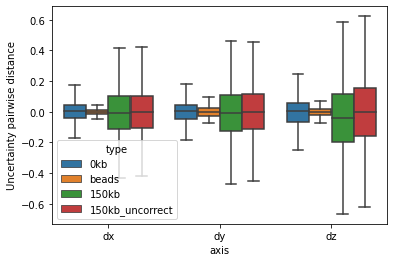

In [14]:
import seaborn as sns
fig = sns.boxplot(data = pd.concat([data, databeads, data150kb,data150kb1]), x="variable", y="value", hue="type", showfliers=False)
plt.xlabel("axis")
plt.ylabel("Uncertainty pairwise distance")
plt.savefig("")
pdf.savefig(fig.figure)

In [16]:
a = pd.concat([data, databeads, data150kb,data150kb1])
a.type.value_counts()

150kb              848955
150kb_uncorrect    848955
0kb                 69453
beads                2226
Name: type, dtype: int64

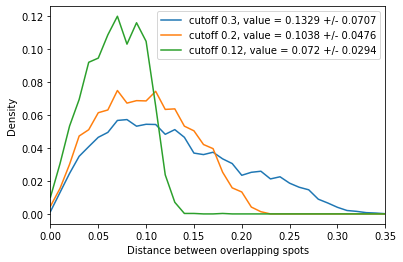

In [19]:
m3 = round(np.mean(res[res["dist_cutoff"] == 0.3]["distance_after"]), 4)
m2 = round(np.mean(res[res["dist_cutoff"] == 0.2]["distance_after"]), 4)
m1 = round(np.mean(res[res["dist_cutoff"] == 0.12]["distance_after"]), 4)

s3 = round(np.std(res[res["dist_cutoff"] == 0.3]["distance_after"]), 4)
s2 = round(np.std(res[res["dist_cutoff"] == 0.2]["distance_after"]), 4)
s1 = round(np.std(res[res["dist_cutoff"] == 0.12]["distance_after"]), 4)

hists = []
hist = plt.hist(res.loc[res.dist_cutoff == 0.3, "distance_after"], alpha=0.5, density=True, bins=np.arange(0,5,0.01))
hists.append(hist)
hist = plt.hist(res.loc[res.dist_cutoff == 0.2, "distance_after"], alpha=0.5, density=True, bins=np.arange(0,5,0.01))
hists.append(hist)
hist = plt.hist(res.loc[res.dist_cutoff == 0.12, "distance_after"], alpha=0.5, density=True, bins=np.arange(0,5,0.01))
hists.append(hist)

plt.close()
fig = plt.figure()

for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))
    
plt.xlabel("Distance between overlapping spots")
plt.ylabel("Density")
plt.legend(
    [
        f"cutoff 0.3, value = {m3} +/- {s3}",
        f"cutoff 0.2, value = {m2} +/- {s2}",
        f"cutoff 0.12, value = {m1} +/- {s1}",
    ]
)
plt.xlim(0,0.35)

pdf.savefig(fig)

In [20]:
pdf.close()

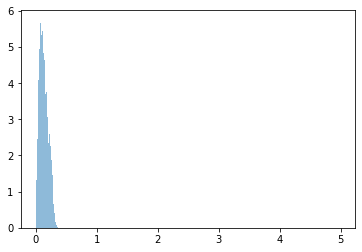

In [21]:
hist = plt.hist(res.loc[res.dist_cutoff == 0.3, "distance_after"], alpha=0.5, density=True, bins=np.arange(0,5,0.01))

(array([1689., 3813., 4410., 4083., 3084., 2349., 1884., 1320.,  444.,
          75.]),
 array([0.0049856 , 0.03966082, 0.07433604, 0.10901126, 0.14368648,
        0.17836169, 0.21303691, 0.24771213, 0.28238735, 0.31706257,
        0.35173779]),
 <BarContainer object of 10 artists>)

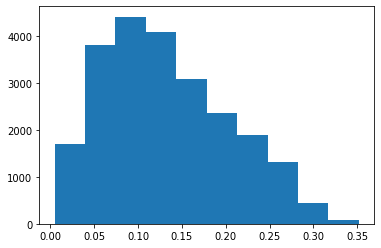

In [27]:
plt.hist(res[res['dist_cutoff'] == 0.3]['distance_after'])

In [29]:
a = res[res['dist_cutoff'] == 0.3]['distance_after']
a.to_csv("FigureS4L.csv", index=False)